Outputs for data_east/results:
         system_cost          carbon system_capacity wave_capacity  \
0  1005394586.456878             0.0    59532.273479  49090.267197   
1  1834812074.587211   739274.734543    38799.102645  18041.050537   
2  2293404513.501224  6088679.112948    39048.498602  12609.004257   

  solar_capacity onshore_wind_capacity offshore_wind_capacity  \
0          621.9                1366.3                   29.3   
1          621.9                1366.3                   29.3   
2     3779.23475                1366.3                   29.3   

  battery_capacity       wave_profit  
0              0.0 -102964445.343739  
1        31.717739  -95507618.469402  
2           51.244  -88021088.104616  
Weccost: [ 10000 155000 300000]


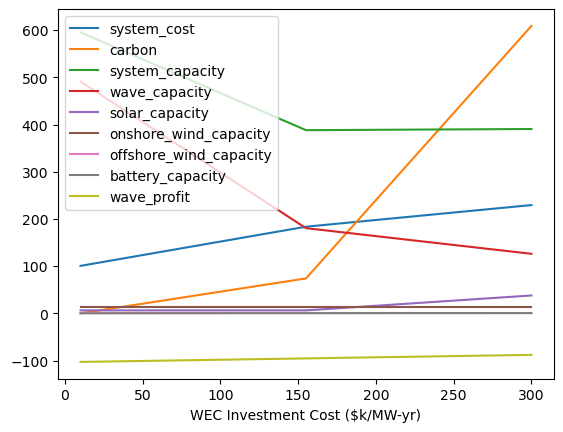

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

location = 'data_east'
inputs = pd.read_csv(os.path.join(location,'scenario_input.csv'))
result_folders = [os.path.join(location,'results')]
output_cols = ['system_cost', 'carbon', 'system_capacity','wave_capacity', 'solar_capacity', \
               'onshore_wind_capacity', 'offshore_wind_capacity', 'battery_capacity','wave_profit'] 
outputs = pd.DataFrame(index=inputs.index, columns=output_cols)
output_scale = {'system_cost': 1e7, 'carbon': 1e4, 'system_capacity': 100, \
                'wave_capacity': 100, 'solar_capacity': 100, \
                'onshore_wind_capacity': 100, 'offshore_wind_capacity': 100, \
                'battery_capacity': 100, 'wave_profit': 1e6}

wave_name = 'wave'
solar_name = ['utilitypv','solar_photovoltaic']
onshore_wind_name = ['onshore_wind','landbasedwind']
offshore_wind_name = ['offshore_wind','offshorewind']
battery_name = ['battery','batteries']

for result_folder in result_folders:
    for case in np.arange(1,len(inputs)+1):
        idx = case - 1
        case_result_folder = os.path.join(result_folder,'Case_'+str(case),'Inputs','Inputs_p1','results_1')
        cost_file     = os.path.join(case_result_folder,'costs.csv')
        carbon_file   = os.path.join(case_result_folder,'emissions.csv')
        capacity_file = os.path.join(case_result_folder,'capacity.csv')
        revenue_file  = os.path.join(case_result_folder,'NetRevenue.csv')

        system_cost_df   = pd.read_csv(cost_file,     index_col='Costs')
        carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3)
        capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap'])
        profit_df   = pd.read_csv(revenue_file,  index_col='Resource',usecols=['Resource','Profit'])
    
        system_cost = system_cost_df['Total'].loc['cTotal']
        carbon = carbon_df['Total'].loc['AnnualSum']
        wave_profit_idx = profit_df['Profit'].index.str.contains(wave_name, regex=True)
        wave_profit = profit_df['Profit'].loc[wave_profit_idx].sum()
        system_capacity = capacity_df['EndCap'].loc['Total']

        wave_idx = capacity_df.index.str.contains(wave_name, regex=True)
        wave_capacity = capacity_df['EndCap'].loc[wave_idx].sum()
        pct_wave_capacity = wave_capacity / system_capacity

        solar_idx = capacity_df.index.str.contains('|'.join(solar_name), regex=True)
        solar_capacity = sum(capacity_df['EndCap'].loc[solar_idx])
        pct_solar_capacity = solar_capacity / system_capacity

        onshore_wind_idx = capacity_df.index.str.contains('|'.join(onshore_wind_name), regex=True)
        onshore_wind_capacity = sum(capacity_df['EndCap'].loc[onshore_wind_idx])
        pct_onshore_wind_capacity = onshore_wind_capacity / system_capacity

        offshore_wind_idx = capacity_df.index.str.contains('|'.join(offshore_wind_name), regex=True)
        offshore_wind_capacity = sum(capacity_df['EndCap'].loc[offshore_wind_idx])
        pct_offshore_wind_capacity = offshore_wind_capacity / system_capacity

        battery_idx = capacity_df.index.str.contains('|'.join(battery_name), regex=True)
        battery_capacity = sum(capacity_df['EndCap'].loc[battery_idx])
        pct_battery_capacity = battery_capacity / system_capacity

        outputs.loc[idx] = [system_cost, carbon, system_capacity,\
                            wave_capacity, solar_capacity, onshore_wind_capacity,\
                            offshore_wind_capacity, battery_capacity, wave_profit]

    outputs.reset_index(drop=True, inplace=True)
    print(f"Outputs for {result_folder}:")
    print(outputs)

    # extract inputs
    wec_cost_str = inputs.wave_cost.values
    wec_cost_lut = {'low': 10000, 'mid': 155000, 'high': 300000}
    wec_cost = np.array([wec_cost_lut[cost] for cost in wec_cost_str])
    print(f"Weccost: {wec_cost}")
    wave_variability = inputs.wave_variability.values #np.array2string(inputs.wave_variability.values)
    test = float('200')
    power_lim = np.array([float(v.rsplit('_')[-1]) for v in wave_variability])
    omega_n   = np.array([float(v.rsplit('_')[-3]) for v in wave_variability])
    zeta      = np.array([float(v.rsplit('_')[2])  for v in wave_variability])

    # determine size for reshaping
    num_costs = len(np.unique(wec_cost))
    num_power_limits = len(np.unique(power_lim))
    size_tuple = (num_costs, num_power_limits)

    # reshape inputs for plotting
    wec_cost = np.reshape(wec_cost, size_tuple)
    power_lim = np.reshape(power_lim, size_tuple)
    # ignore omega_n and zeta for now, not used in plotting

    # hardcoded based on result - in the future do this programatically
    x = 250/8
    points = np.array([[300+x,   0.03],
                       [300-x,   0.03],
                       [300-x,   0.05],
                       [300-3*x, 0.05],
                       [300-3*x, 0.09],
                       [300-5*x, 0.09],
                       [300-5*x, 0.11],
                       [300+x,   0.11],
                       [300+x,   0.03]])
    
    if np.any(np.array(size_tuple)==1):
        # line plot
        fig, ax = plt.subplots()
        for output in output_cols:
            output_reshaped = np.reshape(outputs[output].values, size_tuple)
            scale = 1/output_scale[output]
            plt.plot(wec_cost/1000, output_reshaped.astype(float)*scale, label=output)
        plt.xlabel('WEC Investment Cost ($k/MW-yr)')
        plt.legend()
        plt.show()
    else:
        # contour plots
        for output in output_cols:
            output_reshaped = np.reshape(outputs[output].values, size_tuple)
            fig, ax = plt.subplots()
            plt.pcolormesh(wec_cost/1000, power_lim, output_reshaped.astype(float))
            #plt.plot(points[:,0],points[:,1],'r')
            plt.title(output)
            plt.xlabel('WEC Investment Cost ($k/MW-yr)')
            plt.ylabel('WEC Fractional Power Limit')
            plt.colorbar()
            plt.show()    


In [ ]:
pd.DataFrame(inputs)